# **PROJET 6** : Classifiez automatiquement des biens de consommation

## 0.1 Import des données

In [1]:
import pandas as pd

df = pd.read_csv(r'Flipkart/flipkart_com-ecommerce_sample_1050.csv')
df.head(2).T

0  \
uniq_id                                   55b85ea15a1536d46b7190ad6fff8ce7   
crawl_timestamp                                  2016-04-30 03:22:56 +0000   
product_url              http://www.flipkart.com/elegance-polyester-mul...   
product_name             Elegance Polyester Multicolor Abstract Eyelet ...   
product_category_tree    ["Home Furnishing >> Curtains & Accessories >>...   
pid                                                       CRNEG7BKMFFYHQ8Z   
retail_price                                                          1899   
discounted_price                                                       899   
image                                 55b85ea15a1536d46b7190ad6fff8ce7.jpg   
is_FK_Advantage_product                                              False   
description              Key Features of Elegance Polyester Multicolor ...   
product_rating                                         No rating available   
overall_rating                                         No rating available   
brand                                                             Elegance   
product_specifications   {"product_specification"=>[{"key"=>"Brand", "v...   

                                                                         1  
uniq_id                                   7b72c92c2f6c40268628ec5f14c6d590  
crawl_timestamp                                  2016-04-30 03:22:56 +0000  
product_url              http://www.flipkart.com/sathiyas-cotton-bath-t...  
product_name                                    Sathiyas Cotton Bath Towel  
product_category_tree    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  
pid                                                       BTWEGFZHGBXPHZUH  
retail_price                                                           600  
discounted_price                                                       449  
image                                 7b72c92c2f6c40268628ec5f14c6d590.jpg  
is_FK_Advantage_product                                              False  
description              Specifications of Sathiyas Cotton Bath Towel (...  
product_rating                                         No rating available  
overall_rating                                         No rating available  
brand                                                             Sathiyas  
product_specifications   {"product_specification"=>[{"key"=>"Machine Wa...

## 1. Étude des catégories de produits

In [2]:
df['product_category_tree'][1]

'["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]'

Extraction de la catégorie principale :

In [3]:
df['main_cate'] = df.product_category_tree.map(lambda x: x[2:].split(sep='>>')[0])

df['main_cate']

0       Home Furnishing 
1             Baby Care 
2             Baby Care 
3       Home Furnishing 
4       Home Furnishing 
              ...       
1045          Baby Care 
1046          Baby Care 
1047          Baby Care 
1048          Baby Care 
1049          Baby Care 
Name: main_cate, Length: 1050, dtype: object

In [4]:
import plotly.graph_objects as go

value_cont = pd.DataFrame.from_dict(dict(df['main_cate'].value_counts())
                                ,orient='index')

labels = value_cont.index
values = value_cont[0]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])

fig.update_layout(
    title_text='Répartition des catégories')

fig.show()

## 2. Prétraitement de "description"

Afin de réaliser un POC d'un moteur de classification basé sur le texte, commençons par prétraiter la description des produits.

In [5]:
df['description'][2]

'Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is 100% cotton, so it is susceptible to shrinkage. Product color may vary from the picture. Size may vary by ±3% WASH CARE: Wash in cold Water, Do not Iron, Do not Bleach, Flat dry, Wash before first use. SIZE- FACE TOWEL - 23 cms X 23 cms.,Specifications of Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Bath Towel Features Material Cotton Terry Design SHUVAM General Brand Eurospa GSM 360 Type Face Towel Set Model N

### 2.1 Nettoyage
* Supprimer les mots entre parenthèses
* Supprimer les ID (mot contenant à la fois des caractères alphabétique et numérique)
* Supprimer les nombres seuls
* Suppprimer les stopwords

In [6]:
import re

# Supprimer les mots entre parenthèses
desc_noPrentheses = df.description.map(lambda x: re.sub(" \([^)]*\)", '', x))

# Supprimer les ID (mot contenant à la fois des caractères alphabétique et numérique)
desc_noPrentheses_noID = desc_noPrentheses.map(lambda x: re.sub("^\d+\s|\s\d+\s|\s\d+$", '', x))

# Supprimer les nombres seuls
desc_noPrentheses_noID_noDigit = desc_noPrentheses_noID.map(lambda x: re.sub("[0-9]", '', x))

In [7]:
desc_noPrentheses_noID_noDigit[2]

'Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height:inch GSM: ,Eurospa Cotton Terry Face Towel Set Price: Rs.Eurospa brings to you an exclusively designed, % soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for lastyears and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is % cotton, so it is susceptible to shrinkage. Product color may vary from the picture. Size may vary by ±% WASH CARE: Wash in cold Water, Do not Iron, Do not Bleach, Flat dry, Wash before first use. SIZE- FACE TOWEL -cms Xcms.,Specifications of Eurospa Cotton Terry Face Towel Set Bath Towel Features Material Cotton Terry Design SHUVAM General Brand Eurospa GSMType Face Towel Set Model Name SHUVAMPCFTSETASSORTED Ideal For Boys, Girls, Men, Women Model ID SHUVAMPCFTSETASSORTED Size small Color

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(desc_noPrentheses_noID_noDigit)

In [9]:
mostCommonWord = pd.Series(tokenizer.word_counts).sort_values(ascending=False)[:35]

mostCommonWord[:2]

of     1453
for    1436
dtype: int64

C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 13 missing from current font.

C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning:

Glyph 13 missing from current font.



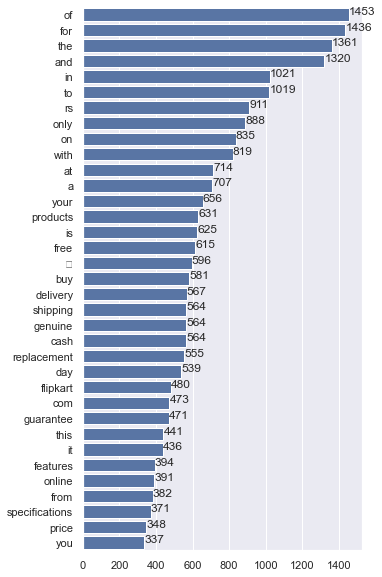

In [10]:
import p5Lib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(x=mostCommonWord.values,
   y=mostCommonWord.index,
   color='b',
   orient='h')
p5Lib.show_values_on_bars(ax, vertical=False);

#### 2.1.1 Création d'un liste soptword

In [11]:
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [12]:
set(mostCommonWord.index) - set(stopwords.words('english'))

{'\r',
 'buy',
 'cash',
 'com',
 'day',
 'delivery',
 'features',
 'flipkart',
 'free',
 'genuine',
 'guarantee',
 'online',
 'price',
 'products',
 'replacement',
 'rs',
 'shipping',
 'specifications'}

In [13]:
mostCommonWord

of                1453
for               1436
the               1361
and               1320
in                1021
to                1019
rs                 911
only               888
on                 835
with               819
at                 714
a                  707
your               656
products           631
is                 625
free               615
\r                 596
buy                581
delivery           567
shipping           564
genuine            564
cash               564
replacement        555
day                539
flipkart           480
com                473
guarantee          471
this               441
it                 436
features           394
online             391
from               382
specifications     371
price              348
you                337
dtype: int64

Consolidation de la liste avec nos mots les plus utilisés :

In [14]:
stop_words_conso = stop_words.union(set(mostCommonWord.index))
stop_words_conso

{'\r',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'buy',
 'by',
 'can',
 'cash',
 'com',
 'couldn',
 "couldn't",
 'd',
 'day',
 'delivery',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'features',
 'few',
 'flipkart',
 'for',
 'free',
 'from',
 'further',
 'genuine',
 'guarantee',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 '

Suppression des stopwords :

In [15]:
desc_noPrentheses_noID_noDigit_stopwords = desc_noPrentheses_noID_noDigit.map(lambda x: ' '.join([w for w in x.split() if not w.lower() in stop_words_conso]))

In [16]:
desc_noPrentheses_noID_noDigit[1]

'Specifications of Sathiyas Cotton Bath Towel Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSMModel Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl Color Red, Yellow, Blue Size Mediam Dimensions Lengthinch Widthinch In the Box Number of Contents in Sales PackageSales PackageBath Towel'

In [17]:
desc_noPrentheses_noID_noDigit_stopwords[0]

'Key Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain Price: Rs.This curtain enhances look interiors.This curtain made % high quality polyester fabric.It eyelet style stitch Metal Ring.It makes room environment romantic loving.This curtain ant- wrinkle anti shrinkage elegant apparance.Give home bright modernistic appeal designs. surreal attention sure steal hearts. contemporary eyelet valance curtains slide smoothly draw apart first thing morning welcome bright sun rays want wish good morning whole world draw close evening, create special moments joyous beauty given soothing prints. Bring home elegant curtain softly filters light room get right amount sunlight.,Specifications Elegance Polyester Multicolor Abstract Eyelet Door Curtain General Brand Elegance Designed Door Type Eyelet Model Name Abstract Polyester Door Curtain Set OfModel ID Duster Color Multicolor Dimensions Lengthcm Box Number Contents S

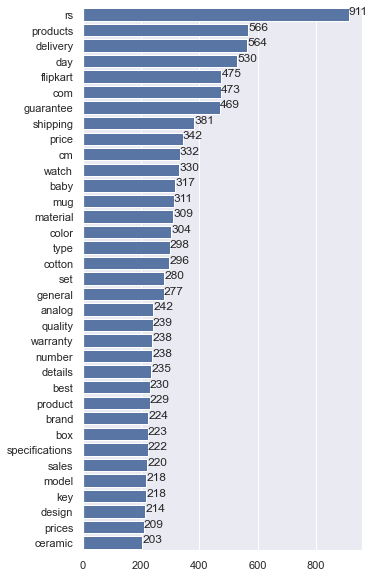

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(desc_noPrentheses_noID_noDigit_stopwords)

mostCommonWord = pd.Series(tokenizer.word_counts).sort_values(ascending=False)[:35]

fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(x=mostCommonWord.values,
   y=mostCommonWord.index,
   color='b',
   orient='h')
p5Lib.show_values_on_bars(ax, vertical=False);

#### 2.1.2 Lemma

In [19]:
tokenizer_alphaNum = nltk.RegexpTokenizer(r'\w+')
desc_noPrentheses_noID_noDigit_stopwords_token = desc_noPrentheses_noID_noDigit_stopwords.map(lambda x: tokenizer_alphaNum.tokenize(x))
desc_noPrentheses_noID_noDigit_stopwords_token

0       [Key, Elegance, Polyester, Multicolor, Abstrac...
1       [Sathiyas, Cotton, Bath, Towel, Bath, Towel, M...
2       [Key, Eurospa, Cotton, Terry, Face, Towel, Set...
3       [Key, SANTOSH, ROYAL, FASHION, Cotton, Printed...
4       [Key, Jaipur, Print, Cotton, Floral, King, siz...
                              ...                        
1045    [Oren, Empower, Extra, Large, Self, Adhesive, ...
1046    [Wallmantra, Large, Vinyl, Sticker, Sticker, P...
1047    [Uberlyfe, Extra, Large, Pigmented, Polyvinyl,...
1048    [Wallmantra, Medium, Vinyl, Sticker, Sticker, ...
1049    [Uberlyfe, Large, Vinyl, Sticker, Rs, online, ...
Name: description, Length: 1050, dtype: object

In [20]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
desc_lemma = desc_noPrentheses_noID_noDigit_stopwords_token.map(lambda x: ([lemmatizer.lemmatize(w.lower()) for w in x]))
desc_lemma[0]

['key',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'price',
 'r',
 'this',
 'curtain',
 'enhances',
 'look',
 'interior',
 'this',
 'curtain',
 'made',
 'high',
 'quality',
 'polyester',
 'fabric',
 'it',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ring',
 'it',
 'make',
 'room',
 'environment',
 'romantic',
 'loving',
 'this',
 'curtain',
 'ant',
 'wrinkle',
 'anti',
 'shrinkage',
 'elegant',
 'apparance',
 'give',
 'home',
 'bright',
 'modernistic',
 'appeal',
 'design',
 'surreal',
 'attention',
 'sure',
 'steal',
 'heart',
 'contemporary',
 'eyelet',
 'valance',
 'curtain',
 'slide',
 'smoothly',
 'draw',
 'apart',
 'first',
 'thing',
 'morning',
 'welcome',
 'bright',
 'sun',
 'ray',
 'want',
 'wish',
 'good',
 'morning',
 'whole',
 'world',
 'draw',
 'close',
 'evening',
 'create',
 'special',
 'moment',
 'joyous',
 'beauty',
 

Re-suppression des soptwords après lammatisation

In [21]:
desc_lemma_stopwords = desc_lemma.map(lambda x: [w for w in x if not w.lower() in stop_words_conso])

In [22]:
desc_lemma_stopwords

0       [key, elegance, polyester, multicolor, abstrac...
1       [sathiyas, cotton, bath, towel, bath, towel, m...
2       [key, eurospa, cotton, terry, face, towel, set...
3       [key, santosh, royal, fashion, cotton, printed...
4       [key, jaipur, print, cotton, floral, king, siz...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, r...
1047    [uberlyfe, extra, large, pigmented, polyvinyl,...
1048    [wallmantra, medium, vinyl, sticker, sticker, ...
1049    [uberlyfe, large, vinyl, sticker, r, uberlyfe,...
Name: description, Length: 1050, dtype: object

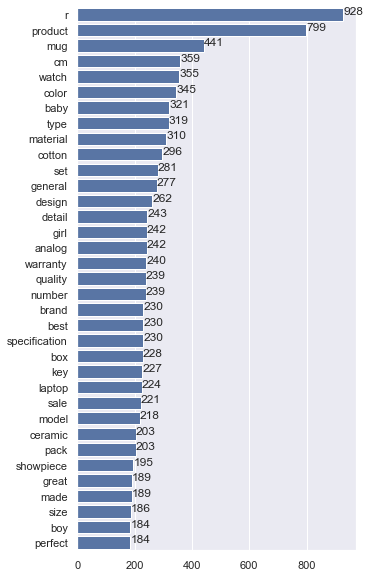

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(desc_lemma_stopwords)

mostCommonWord = pd.Series(tokenizer.word_counts).sort_values(ascending=False)[:35]

fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(x=mostCommonWord.values,
   y=mostCommonWord.index,
   color='b',
   orient='h')
p5Lib.show_values_on_bars(ax, vertical=False);

Re-consolidation des stopwords :

In [24]:
stop_words_hand = set(['r',
                      'product',
                      'com',
                      'flipkart',
                      'rs',
                      'cm',
                      'color',
                      'day',
                      'type',
                      'products',
                      "'s",
                      'warranty',
                      'number',
                      'general',
                      'quality',
                      'best',
                      'brand',
                      'specification',
                      'model',
                      'sale',
                      'model',
                      'pack',
                      'made',
                      'great',
                      'size',
                      'dimension',
                      'material',
                      'set',
                      'detail',
                      'one',
                      'content'])

In [25]:
stop_words_conso2 = stop_words_conso.union(stop_words_hand)

In [26]:
desc_lemma_stopwords2 = desc_lemma_stopwords.map(lambda x: [w for w in x if not w.lower() in stop_words_conso2])

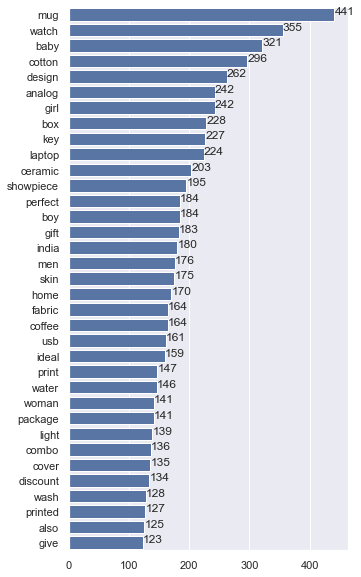

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(desc_lemma_stopwords2)

mostCommonWord = pd.Series(tokenizer.word_counts).sort_values(ascending=False)[:35]

fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(x=mostCommonWord.values,
   y=mostCommonWord.index,
   color='b',
   orient='h')
p5Lib.show_values_on_bars(ax, vertical=False);

## 3. Extraction des features

### 3.1 TF-IDF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

X = tfidf.fit_transform(desc_lemma_stopwords2.map(lambda x: ' '.join(k for k in x)))

In [29]:
features_names = tfidf.get_feature_names()
features_names

dense = X.todense()

denselist = dense.tolist()

tfidf_matrix = pd.DataFrame(denselist, columns=features_names)
tfidf_matrix

_blk   _g   _w   aa  aaa  aapno  aari  aarika  ability  \
0      0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
1      0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
2      0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
3      0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
4      0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
...    ...  ...  ...  ...  ...    ...   ...     ...      ...   
1045   0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
1046   0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
1047   0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
1048   0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
1049   0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   

      abkl_grn_grn_grn  ...  zikrak  zingalalaa  zip  zipexterior  zipper  \
0                  0.0  ...     0.0         0.0  0.0          0.0     0.0   
1                  0.0  ...     0.0         0.0  0.0          0.0     0.0   
2                  0.0  ...     0.0         0.0  0.0          0.0     0.0   
3                  0.0  ...     0.0         0.0  0.0          0.0     0.0   
4                  0.0  ...     0.0         0.0  0.0          0.0     0.0   
...                ...  ...     ...         ...  ...          ...     ...   
1045               0.0  ...     0.0         0.0  0.0          0.0     0.0   
1046               0.0  ...     0.0         0.0  0.0          0.0     0.0   
1047               0.0  ...     0.0         0.0  0.0          0.0     0.0   
1048               0.0  ...     0.0         0.0  0.0          0.0     0.0   
1049               0.0  ...     0.0         0.0  0.0          0.0     0.0   

      zippered  zone  zoom  zora  zyxel  
0          0.0   0.0   0.0   0.0    0.0  
1          0.0   0.0   0.0   0.0    0.0  
2          0.0   0.0   0.0   0.0    0.0  
3          0.0   0.0   0.0   0.0    0.0  
4          0.0   0.0   0.0   0.0    0.0  
...        ...   ...   ...   ...    ...  
1045       0.0   0.0   0.0   0.0    0.0  
1046       0.0   0.0   0.0   0.0    0.0  
1047       0.0   0.0   0.0   0.0    0.0  
1048       0.0   0.0   0.0   0.0    0.0  
1049       0.0   0.0   0.0   0.0    0.0  

[1050 rows x 5060 columns]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

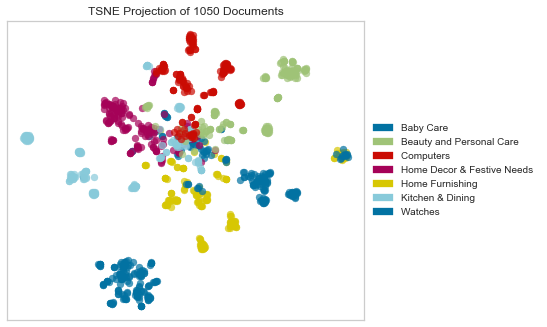

In [30]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit(tfidf_matrix, y=df.main_cate)
tsne.show();

In [31]:
from sklearn import manifold
import numpy as np

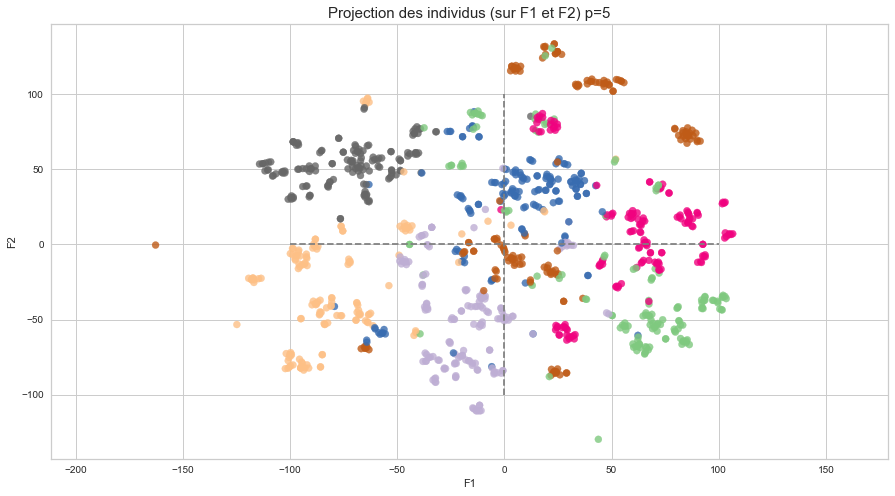

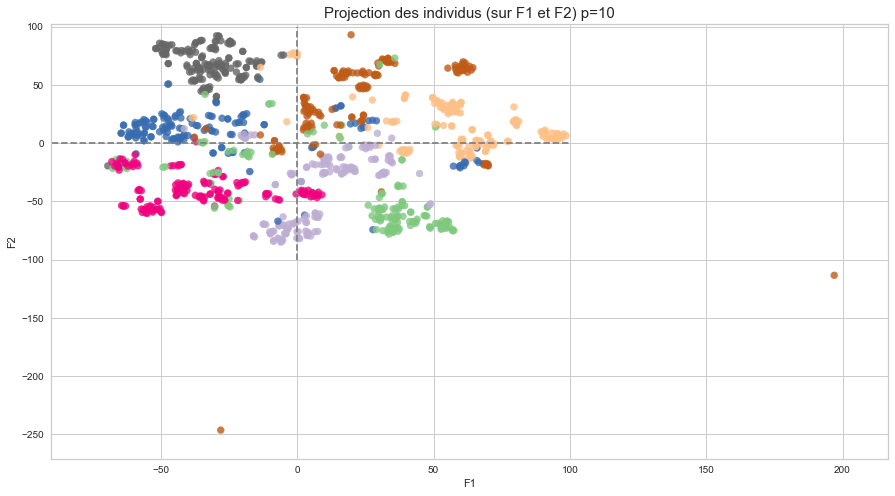

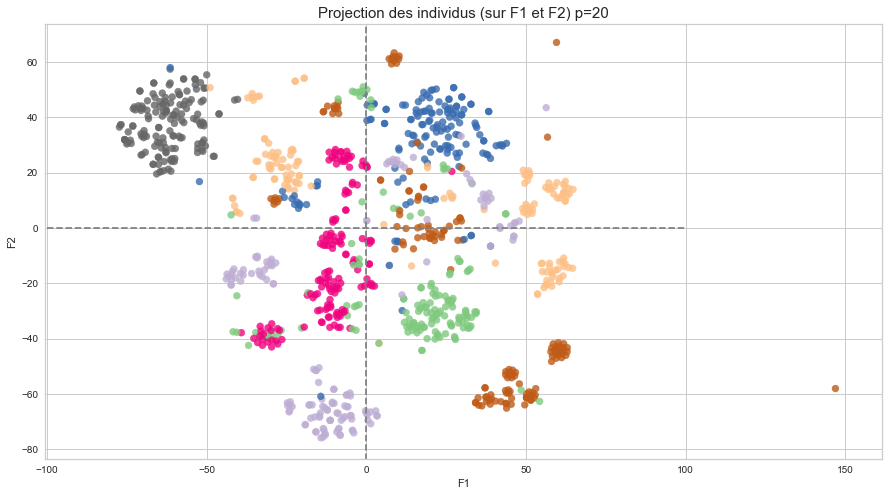

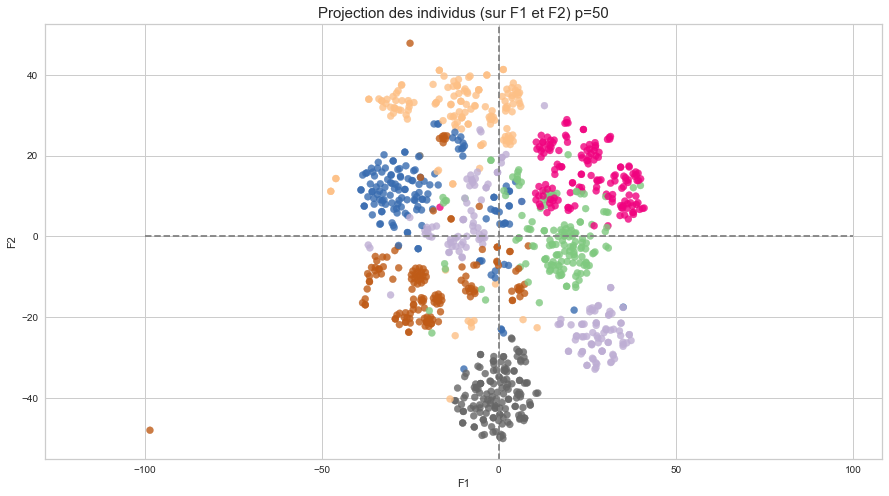

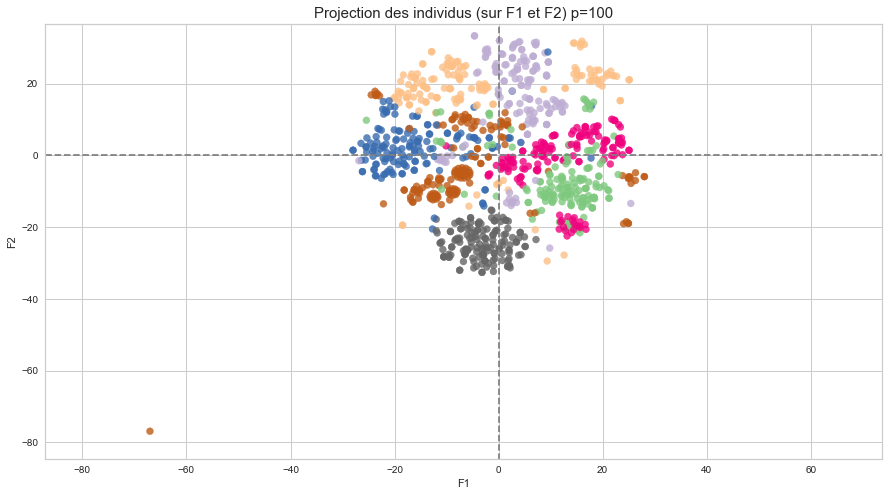

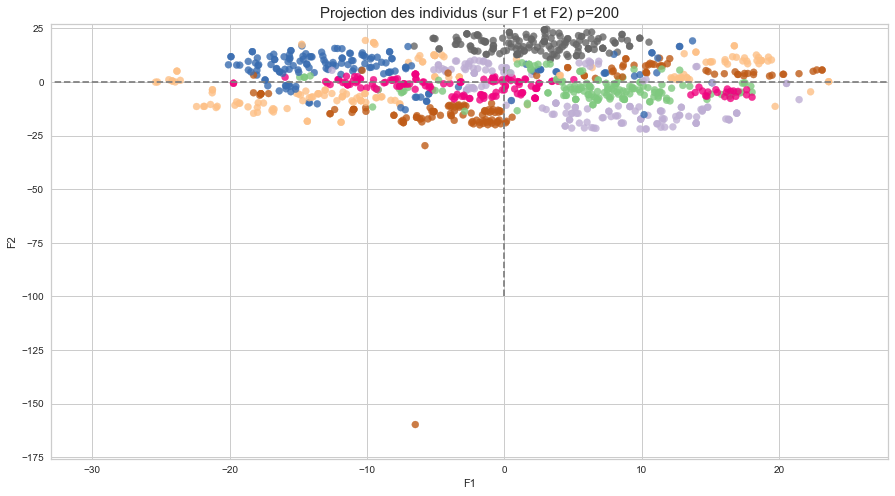

In [32]:
for perplex in [5, 10, 20, 50, 100, 200]:
    tsne = manifold.TSNE(
            n_components=2,  # for projection in a plane
            perplexity=perplex,
            n_iter=2500,
            init='pca',  # initialisation by a PCA
            random_state=0,
            early_exaggeration=20,
        )

    X_tsne = tsne.fit_transform(tfidf_matrix)

    fig = plt.figure(figsize=(15, 8))

    plt.scatter(
        X_tsne[:, 0],
        X_tsne[:, 1],
        c=pd.Categorical(df.main_cate).codes,
        cmap=plt.cm.get_cmap('Accent'),
        alpha=0.8
    )

#     cbar = plt.colorbar()
#     cbar.ax.get_yaxis().set_ticks([])
#     cbar.ax.get_yaxis().labelpad = 15
#     cbar.set_label('mean_price_log', rotation=90)

    # détermination des limites du graphique
    boundary_right = np.max(np.abs(X_tsne[:, 0])) * 1.1
    boundary_left = np.min(X_tsne[:, 0]) * 1.3
    boundary_up = np.max(X_tsne[:, 1]) * 1.1
    boundary_down = np.min(X_tsne[:, 1]) * 1.1
    plt.xlim([boundary_left, boundary_right])
    plt.ylim([boundary_down, boundary_up])

    # affichage des lignes horizontales et verticales
    plt.plot([-100, 100], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-100, 100], color='grey', ls='--')

    # nom des axes, avec le pourcentage d'inertie expliquée
    plt.xlabel('F1')
    plt.ylabel('F2')

    plt.title(f"Projection des individus (sur F1 et F2) p={perplex}",
              fontsize=15)
    plt.show(block=False)

In [33]:
tsne = manifold.TSNE(
        n_components=2,  # for projection in a plane
        perplexity=50,
        n_iter=2500,
        init='pca',  # initialisation by a PCA
        random_state=0,
        early_exaggeration=20,
    )

X_tsne = tsne.fit_transform(tfidf_matrix)

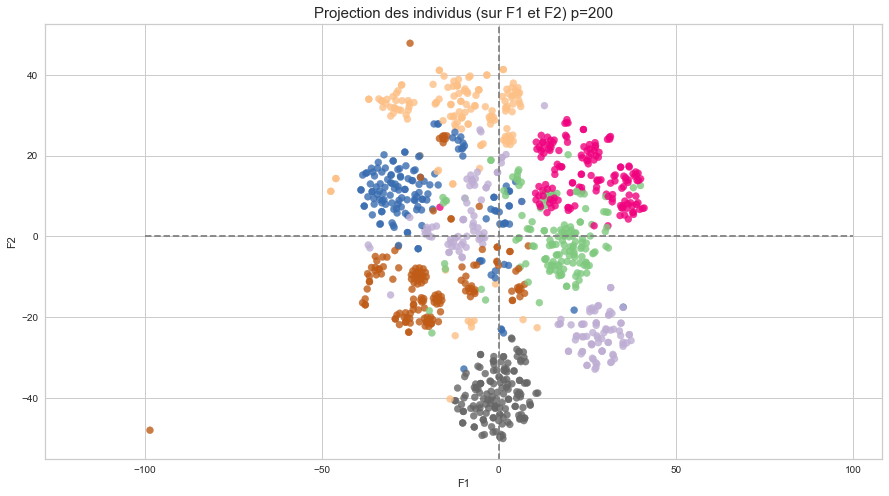

In [34]:
fig = plt.figure(figsize=(15, 8))

plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=pd.Categorical(df.main_cate).codes,
    cmap=plt.cm.get_cmap('Accent'),
    alpha=0.8
)

# détermination des limites du graphique
boundary_right = np.max(np.abs(X_tsne[:, 0])) * 1.1
boundary_left = np.min(X_tsne[:, 0]) * 1.3
boundary_up = np.max(X_tsne[:, 1]) * 1.1
boundary_down = np.min(X_tsne[:, 1]) * 1.1
plt.xlim([boundary_left, boundary_right])
plt.ylim([boundary_down, boundary_up])

# affichage des lignes horizontales et verticales
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')

# nom des axes, avec le pourcentage d'inertie expliquée
plt.xlabel('F1')
plt.ylabel('F2')

plt.title(f"Projection des individus (sur F1 et F2) p={perplex}",
          fontsize=15)
plt.show(block=False)

In [35]:
pd.Categorical(df.main_cate).codes

array([4, 0, 0, ..., 0, 0, 0], dtype=int8)

In [36]:
tfidf_matrix.max().sort_values(ascending=False)[:20]

airtel          1.000000
tenda           1.000000
yardleycombo    1.000000
homedesires     0.908454
spinz           0.906034
purpledip       0.898945
golmaalshop     0.898945
tease           0.891185
smj             0.875527
unravel         0.855261
yl              0.853676
handicraft      0.846683
sl              0.831975
ym              0.826152
suruchi         0.817153
kalash          0.801113
peacock         0.801113
gw              0.799887
mdhn            0.798714
amber           0.798191
dtype: float64

In [37]:
tfidf_matrix.max().sort_values()[:20]

crevice          0.032788
beloved          0.032788
vc_              0.032788
efficient        0.032788
include          0.032788
squeezable       0.032788
effectiveness    0.032788
packagevacuum    0.032788
rid              0.032788
vacuuming        0.032788
heavier          0.032788
shining          0.032788
adjusted         0.032788
vent             0.032788
dusting          0.032788
stuck            0.032788
ancestral        0.032788
stressing        0.034151
security         0.034151
organiser        0.034151
dtype: float64

### 3.2 NMF

In [38]:
from sklearn.decomposition import NMF

no_topics = 7

nmf = NMF(n_components=no_topics, random_state=42, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf_matrix = nmf.fit_transform(tfidf_matrix)

In [39]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [40]:
no_top_words = 10

display_topics(nmf, features_names, no_top_words)

Topic 0:
watch analog men discount india woman dial strap sonata timewel
Topic 1:
mug coffee ceramic perfect tea printland prithish gift get bring
Topic 2:
baby girl dress cotton sleeve boy neck fabric shirt pattern
Topic 3:
rockmantra mug ceramic porcelain crafting thrilling permanent ensuring stay start
Topic 4:
abstract blanket double single quilt comforter raymond multicolor floral original
Topic 5:
laptop skin battery mouse pad shape print hp pavilion lapguard
Topic 6:
towel cotton bath soft hand nkp face terry bornbabykids mandhania


### 3.3 LDA

In [41]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 7

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=50, 
        learning_method='batch', 
        learning_offset=10.,
        random_state=42)

# Fitter sur les données
lda_matrix = lda.fit_transform(tfidf_matrix)

In [42]:
display_topics(lda, features_names, no_top_words)

Topic 0:
sticker wall glass combo cover light vinyl cushion kit medium
Topic 1:
baby cotton girl single boy fabric towel printed dress quilt
Topic 2:
blanket mug abstract double prithish raymond gathered usb bring original
Topic 3:
showpiece mug coffee ceramic gift ym handicraft tea ganesha bottle
Topic 4:
watch analog men india discount woman dial strap sonata maximum
Topic 5:
laptop battery skin combo hp pavilion lapguard adapter shape towel
Topic 6:
tenda pc wireless router combo perucci link pp dsl adidas


In [43]:
tfidf_matrix

_blk   _g   _w   aa  aaa  aapno  aari  aarika  ability  \
0      0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
1      0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
2      0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
3      0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
4      0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
...    ...  ...  ...  ...  ...    ...   ...     ...      ...   
1045   0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
1046   0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
1047   0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
1048   0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
1049   0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   

      abkl_grn_grn_grn  ...  zikrak  zingalalaa  zip  zipexterior  zipper  \
0                  0.0  ...     0.0         0.0  0.0          0.0     0.0   
1                  0.0  ...     0.0         0.0  0.0          0.0     0.0   
2                  0.0  ...     0.0         0.0  0.0          0.0     0.0   
3                  0.0  ...     0.0         0.0  0.0          0.0     0.0   
4                  0.0  ...     0.0         0.0  0.0          0.0     0.0   
...                ...  ...     ...         ...  ...          ...     ...   
1045               0.0  ...     0.0         0.0  0.0          0.0     0.0   
1046               0.0  ...     0.0         0.0  0.0          0.0     0.0   
1047               0.0  ...     0.0         0.0  0.0          0.0     0.0   
1048               0.0  ...     0.0         0.0  0.0          0.0     0.0   
1049               0.0  ...     0.0         0.0  0.0          0.0     0.0   

      zippered  zone  zoom  zora  zyxel  
0          0.0   0.0   0.0   0.0    0.0  
1          0.0   0.0   0.0   0.0    0.0  
2          0.0   0.0   0.0   0.0    0.0  
3          0.0   0.0   0.0   0.0    0.0  
4          0.0   0.0   0.0   0.0    0.0  
...        ...   ...   ...   ...    ...  
1045       0.0   0.0   0.0   0.0    0.0  
1046       0.0   0.0   0.0   0.0    0.0  
1047       0.0   0.0   0.0   0.0    0.0  
1048       0.0   0.0   0.0   0.0    0.0  
1049       0.0   0.0   0.0   0.0    0.0  

[1050 rows x 5060 columns]

In [44]:
nmf_matrix = nmf.fit_transform(tfidf_matrix)

In [45]:
nmf_matrix.shape

(1050, 7)

In [46]:
import numpy as np

np.argmax(nmf_matrix[0]), max(nmf_matrix[0])

(4, 0.05068437422353692)

In [47]:
nmf_topics = pd.DataFrame(nmf_matrix)

In [48]:
topi = []
for line in nmf_matrix:
    topi.append(np.argmax(line))

In [49]:
sco = []
for line in nmf_matrix:
    sco.append(max(line))

In [50]:
nmf_topics['topic'] = topi

In [51]:
nmf_topics['nmf'] = sco

In [52]:
nmf_topics.apply(lambda x: np.argmax(x))

0         796
1         150
2         980
3         189
4         704
5        1015
6         654
topic       1
nmf       189
dtype: int64

In [53]:
nmf_topics

0         1         2         3         4         5         6  \
0     0.000000  0.008097  0.000000  0.000000  0.050684  0.000000  0.000000   
1     0.012269  0.000000  0.009204  0.000000  0.000000  0.000000  0.314370   
2     0.003600  0.000000  0.011320  0.000000  0.000000  0.004418  0.245125   
3     0.000000  0.000000  0.027957  0.000000  0.034716  0.000000  0.030325   
4     0.000000  0.000000  0.025410  0.000000  0.037724  0.014650  0.039850   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1046  0.000000  0.005568  0.000000  0.003697  0.000000  0.015871  0.000000   
1047  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1048  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1049  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

      topic       nmf  
0         4  0.050684  
1         6  0.314370  
2         6  0.245125  
3         4  0.034716  
4         6  0.039850  
...     ...       ...  
1045      0  0.000000  
1046      5  0.015871  
1047      0  0.000000  
1048      0  0.000000  
1049      0  0.000000  

[1050 rows x 9 columns]

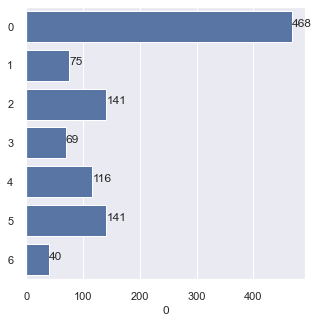

In [54]:
p5Lib.display_cate_bar(nmf_topics, 'topic')

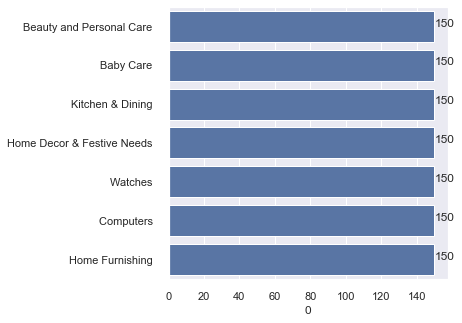

In [55]:
p5Lib.display_cate_bar(df, 'main_cate')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

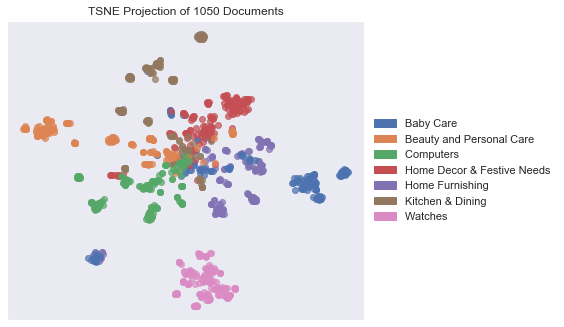

In [56]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit(tfidf_matrix, y=df.main_cate)
tsne.show();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

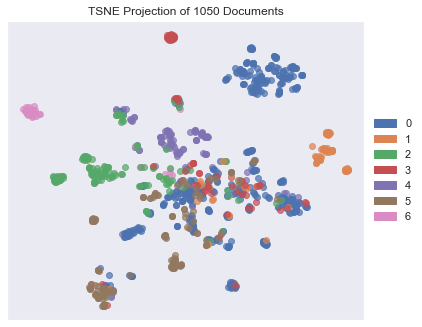

In [57]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit(tfidf_matrix, y=nmf_topics.topic)
tsne.show();

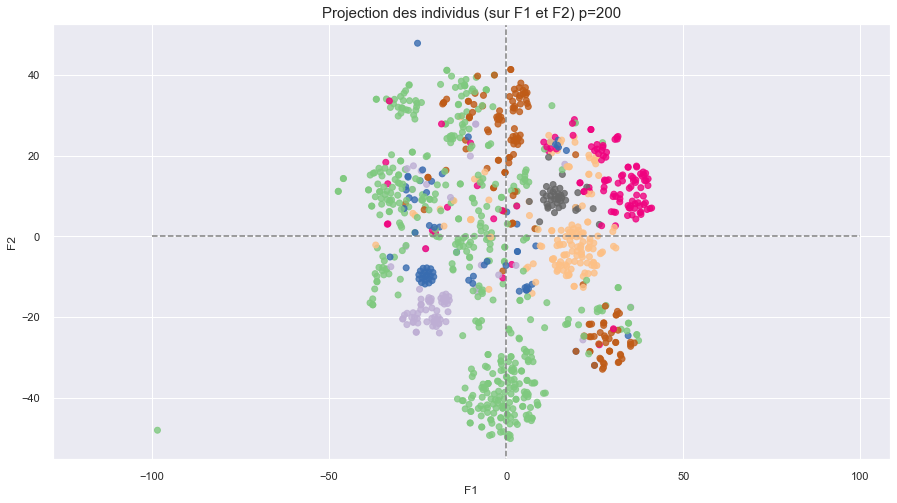

In [58]:
fig = plt.figure(figsize=(15, 8))

plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=pd.Categorical(nmf_topics.topic).codes,
    cmap=plt.cm.get_cmap('Accent'),
    alpha=0.8
)

# détermination des limites du graphique
boundary_right = np.max(np.abs(X_tsne[:, 0])) * 1.1
boundary_left = np.min(X_tsne[:, 0]) * 1.3
boundary_up = np.max(X_tsne[:, 1]) * 1.1
boundary_down = np.min(X_tsne[:, 1]) * 1.1
plt.xlim([boundary_left, boundary_right])
plt.ylim([boundary_down, boundary_up])

# affichage des lignes horizontales et verticales
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')

# nom des axes, avec le pourcentage d'inertie expliquée
plt.xlabel('F1')
plt.ylabel('F2')

plt.title(f"Projection des individus (sur F1 et F2) p={perplex}",
          fontsize=15)
plt.show(block=False)

In [59]:
pd.DataFrame(lda_matrix)

0         1         2         3         4         5         6
0     0.018091  0.496905  0.018170  0.413056  0.017881  0.018061  0.017836
1     0.028288  0.811536  0.028284  0.028291  0.047005  0.028311  0.028285
2     0.021065  0.379687  0.020850  0.021050  0.035853  0.500626  0.020870
3     0.023041  0.567695  0.023873  0.023153  0.316176  0.023032  0.023029
4     0.020944  0.691222  0.020944  0.020965  0.204006  0.020966  0.020953
...        ...       ...       ...       ...       ...       ...       ...
1045  0.275117  0.016903  0.015862  0.173792  0.015739  0.486900  0.015686
1046  0.340714  0.278743  0.303466  0.019206  0.019398  0.019383  0.019090
1047  0.301408  0.039487  0.039479  0.039492  0.039479  0.501177  0.039479
1048  0.705660  0.049054  0.049054  0.049069  0.049052  0.049058  0.049053
1049  0.497720  0.047984  0.047976  0.047991  0.047976  0.262376  0.047976

[1050 rows x 7 columns]

In [60]:
lda.score(tfidf_matrix)

-36804.20416177404

In [61]:
lda_topics = pd.DataFrame(lda_matrix)

In [62]:
topi = []
for line in lda_matrix:
    topi.append(np.argmax(line))

In [63]:
sco = []
for line in lda_matrix:
    sco.append(max(line))

In [64]:
lda_topics['topic'] = topi

In [65]:
lda_topics['nmf'] = sco

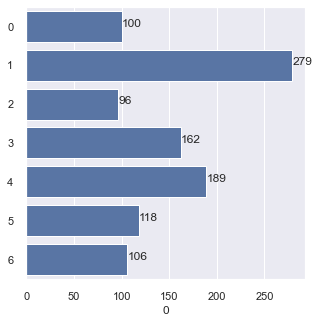

In [66]:
p5Lib.display_cate_bar(lda_topics, 'topic')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

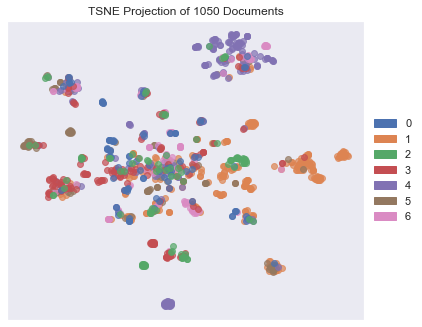

In [67]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit(tfidf_matrix, y=lda_topics.topic)
tsne.show();

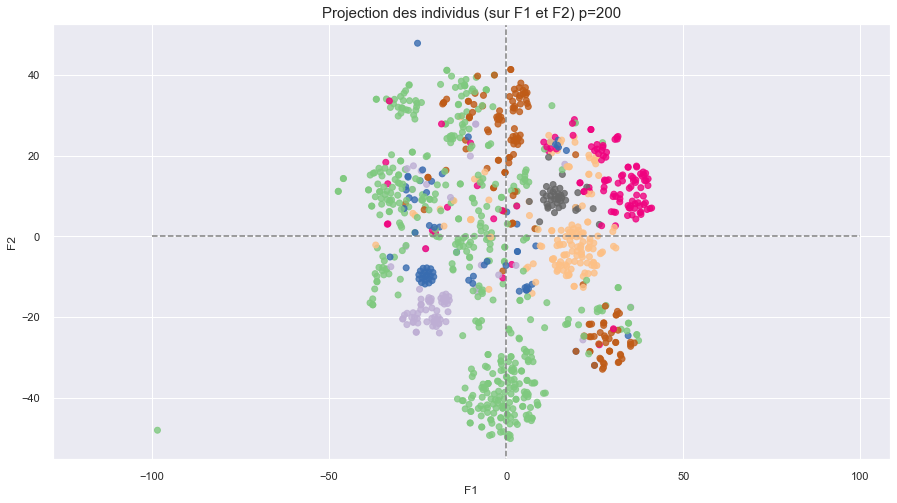

In [68]:
fig = plt.figure(figsize=(15, 8))

plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=pd.Categorical(nmf_topics.topic).codes,
    cmap=plt.cm.get_cmap('Accent'),
    alpha=0.8
)

# détermination des limites du graphique
boundary_right = np.max(np.abs(X_tsne[:, 0])) * 1.1
boundary_left = np.min(X_tsne[:, 0]) * 1.3
boundary_up = np.max(X_tsne[:, 1]) * 1.1
boundary_down = np.min(X_tsne[:, 1]) * 1.1
plt.xlim([boundary_left, boundary_right])
plt.ylim([boundary_down, boundary_up])

# affichage des lignes horizontales et verticales
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')

# nom des axes, avec le pourcentage d'inertie expliquée
plt.xlabel('F1')
plt.ylabel('F2')

plt.title(f"Projection des individus (sur F1 et F2) p={perplex}",
          fontsize=15)
plt.show(block=False)

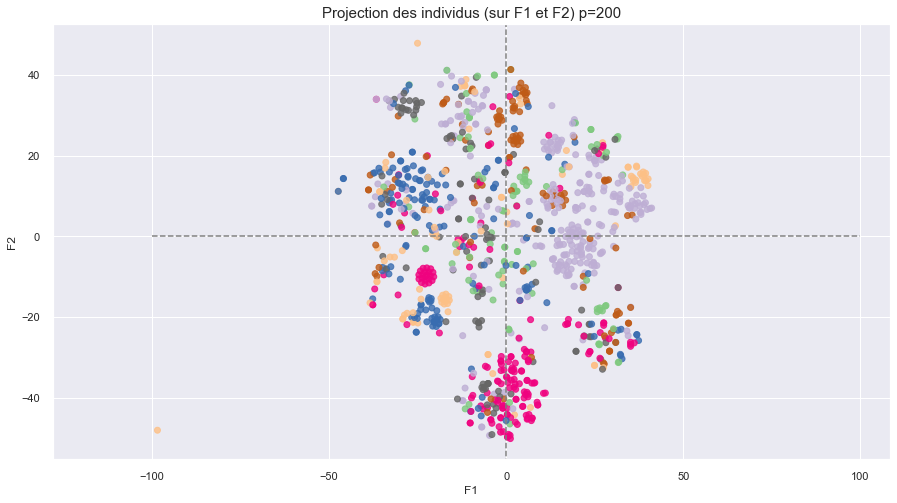

In [69]:
fig = plt.figure(figsize=(15, 8))

plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=pd.Categorical(lda_topics.topic).codes,
    cmap=plt.cm.get_cmap('Accent'),
    alpha=0.8
)

# détermination des limites du graphique
boundary_right = np.max(np.abs(X_tsne[:, 0])) * 1.1
boundary_left = np.min(X_tsne[:, 0]) * 1.3
boundary_up = np.max(X_tsne[:, 1]) * 1.1
boundary_down = np.min(X_tsne[:, 1]) * 1.1
plt.xlim([boundary_left, boundary_right])
plt.ylim([boundary_down, boundary_up])

# affichage des lignes horizontales et verticales
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')

# nom des axes, avec le pourcentage d'inertie expliquée
plt.xlabel('F1')
plt.ylabel('F2')

plt.title(f"Projection des individus (sur F1 et F2) p={perplex}",
          fontsize=15)
plt.show(block=False)

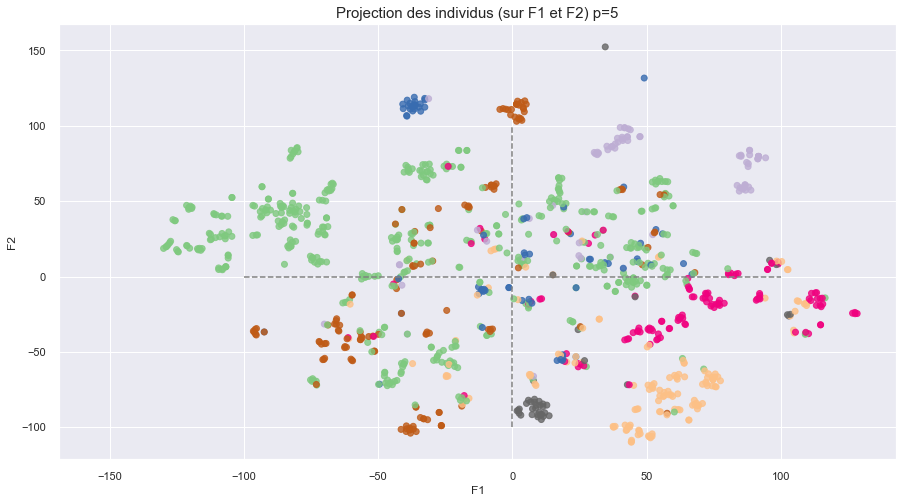

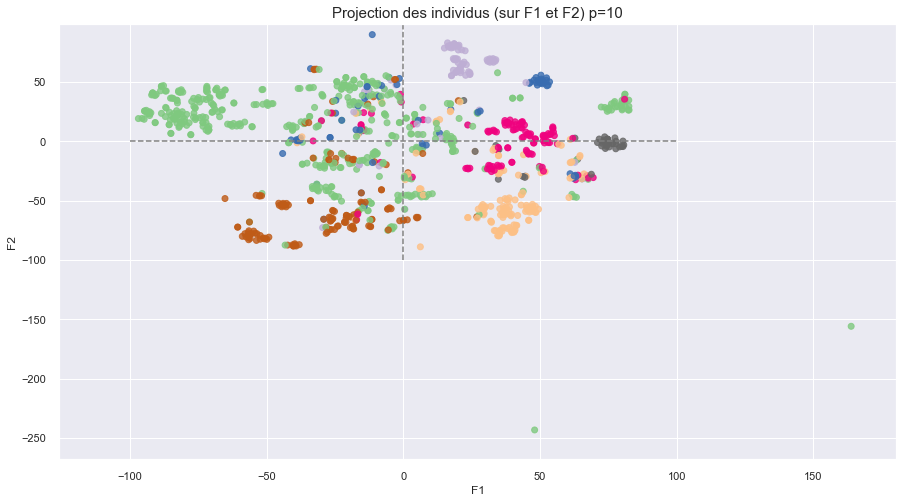

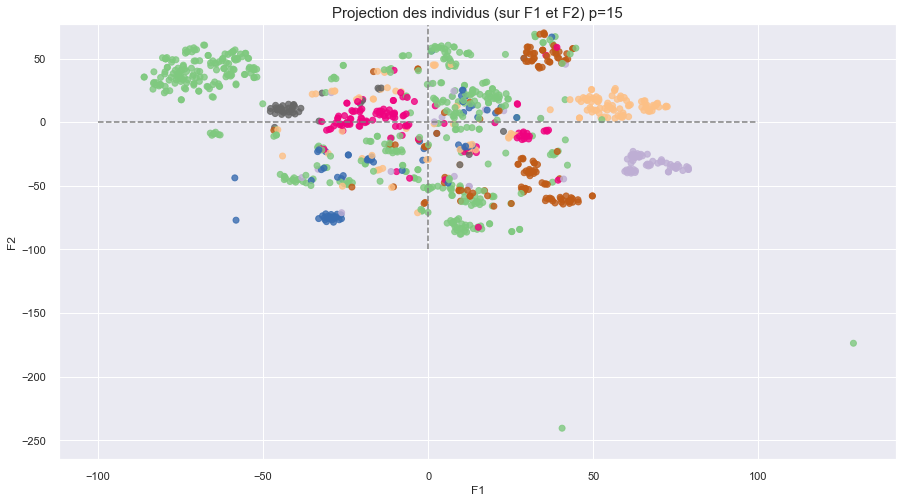

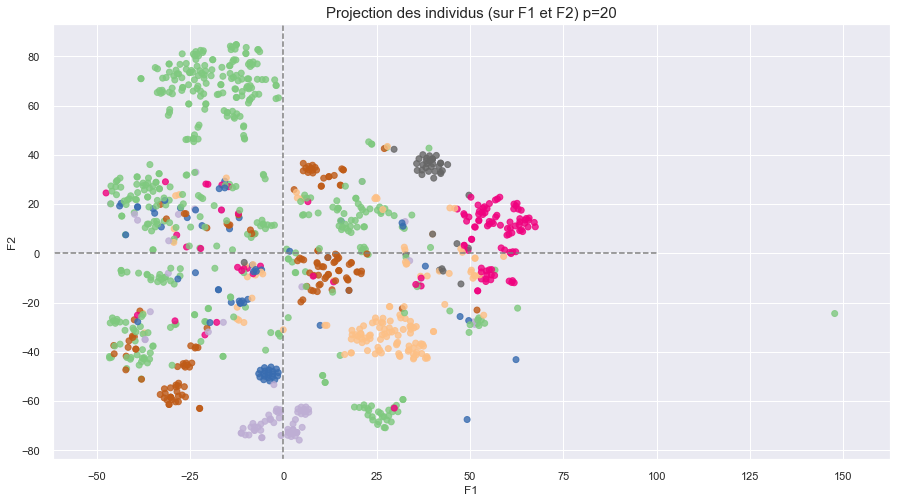

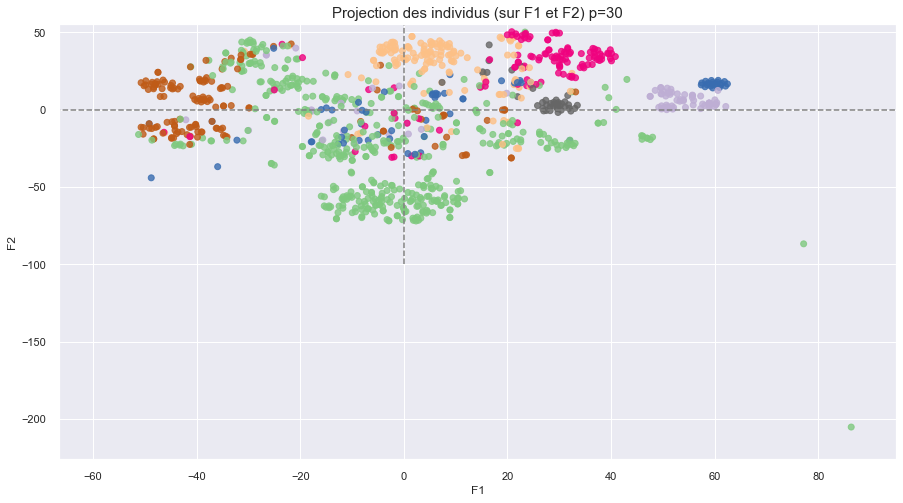

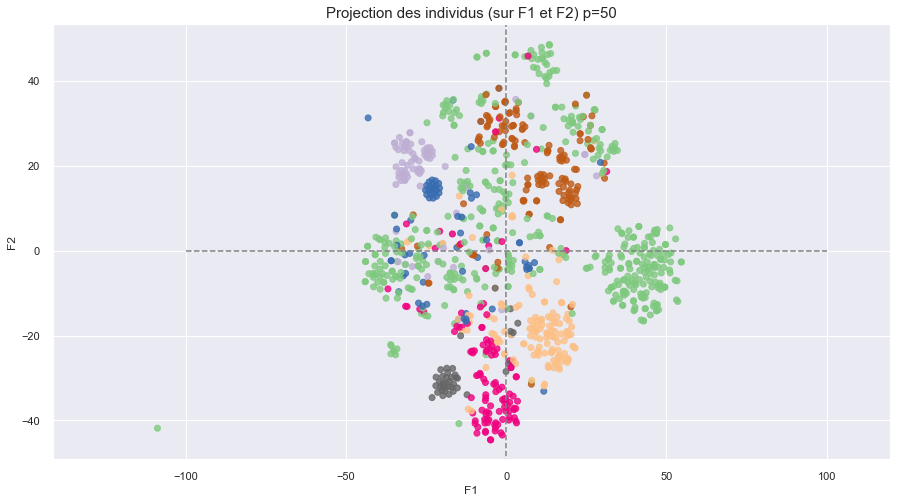

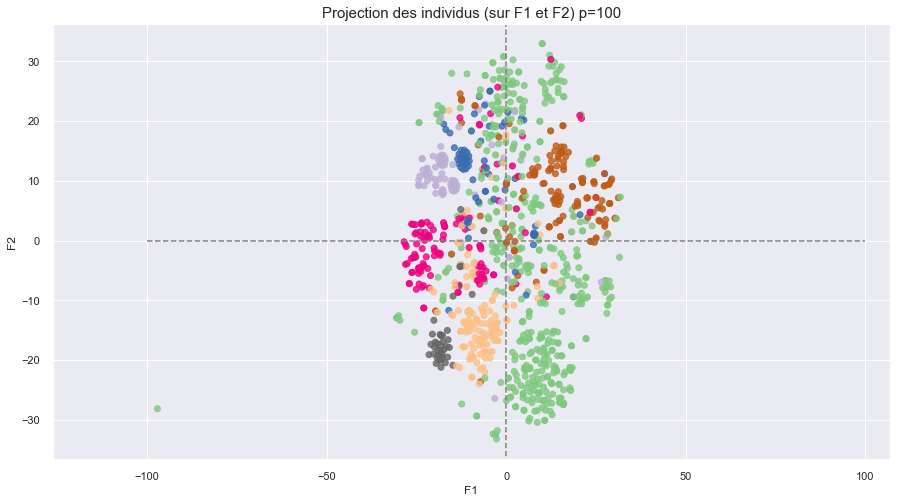

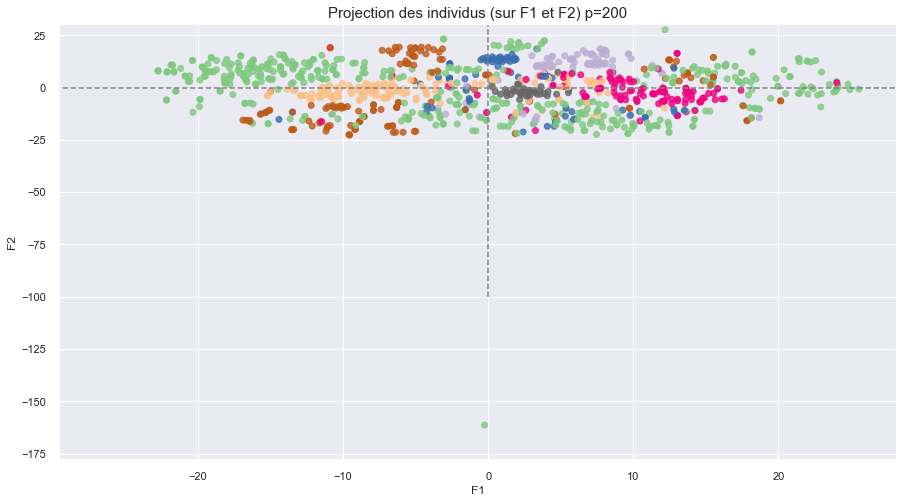

In [75]:
for perplex in [5, 10, 15, 20, 30, 50, 100, 200]:
    tsne = manifold.TSNE(
            n_components=2,  # for projection in a plane
            perplexity=perplex,
            n_iter=2500,
            init='pca',  # initialisation by a PCA
            random_state=42,
            early_exaggeration=25,
        )

    X_tsne = tsne.fit_transform(tfidf_matrix)

    fig = plt.figure(figsize=(15, 8))

    plt.scatter(
        X_tsne[:, 0],
        X_tsne[:, 1],
        c=pd.Categorical(nmf_topics.topic).codes,
        cmap=plt.cm.get_cmap('Accent'),
        alpha=0.8,
        label=pd.Categorical(nmf_topics.topic).codes
    )

#     cbar = plt.colorbar()
#     cbar.ax.get_yaxis().set_ticks([])
#     cbar.ax.get_yaxis().labelpad = 15
#     cbar.set_label('mean_price_log', rotation=90)

    # détermination des limites du graphique
    boundary_right = np.max(np.abs(X_tsne[:, 0])) * 1.1
    boundary_left = np.min(X_tsne[:, 0]) * 1.3
    boundary_up = np.max(X_tsne[:, 1]) * 1.1
    boundary_down = np.min(X_tsne[:, 1]) * 1.1
    plt.xlim([boundary_left, boundary_right])
    plt.ylim([boundary_down, boundary_up])

    # affichage des lignes horizontales et verticales
    plt.plot([-100, 100], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-100, 100], color='grey', ls='--')

    # nom des axes, avec le pourcentage d'inertie expliquée
    plt.xlabel('F1')
    plt.ylabel('F2')

    plt.title(f"Projection des individus (sur F1 et F2) p={perplex}",
              fontsize=15)
    plt.show(block=False)

In [71]:
tfidf_matrix

_blk   _g   _w   aa  aaa  aapno  aari  aarika  ability  \
0      0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
1      0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
2      0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
3      0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
4      0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
...    ...  ...  ...  ...  ...    ...   ...     ...      ...   
1045   0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
1046   0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
1047   0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
1048   0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   
1049   0.0  0.0  0.0  0.0  0.0    0.0   0.0     0.0      0.0   

      abkl_grn_grn_grn  ...  zikrak  zingalalaa  zip  zipexterior  zipper  \
0                  0.0  ...     0.0         0.0  0.0          0.0     0.0   
1                  0.0  ...     0.0         0.0  0.0          0.0     0.0   
2                  0.0  ...     0.0         0.0  0.0          0.0     0.0   
3                  0.0  ...     0.0         0.0  0.0          0.0     0.0   
4                  0.0  ...     0.0         0.0  0.0          0.0     0.0   
...                ...  ...     ...         ...  ...          ...     ...   
1045               0.0  ...     0.0         0.0  0.0          0.0     0.0   
1046               0.0  ...     0.0         0.0  0.0          0.0     0.0   
1047               0.0  ...     0.0         0.0  0.0          0.0     0.0   
1048               0.0  ...     0.0         0.0  0.0          0.0     0.0   
1049               0.0  ...     0.0         0.0  0.0          0.0     0.0   

      zippered  zone  zoom  zora  zyxel  
0          0.0   0.0   0.0   0.0    0.0  
1          0.0   0.0   0.0   0.0    0.0  
2          0.0   0.0   0.0   0.0    0.0  
3          0.0   0.0   0.0   0.0    0.0  
4          0.0   0.0   0.0   0.0    0.0  
...        ...   ...   ...   ...    ...  
1045       0.0   0.0   0.0   0.0    0.0  
1046       0.0   0.0   0.0   0.0    0.0  
1047       0.0   0.0   0.0   0.0    0.0  
1048       0.0   0.0   0.0   0.0    0.0  
1049       0.0   0.0   0.0   0.0    0.0  

[1050 rows x 5060 columns]

In [74]:
nmf_topics

0         1         2         3         4         5         6  \
0     0.000000  0.008097  0.000000  0.000000  0.050684  0.000000  0.000000   
1     0.012269  0.000000  0.009204  0.000000  0.000000  0.000000  0.314370   
2     0.003600  0.000000  0.011320  0.000000  0.000000  0.004418  0.245125   
3     0.000000  0.000000  0.027957  0.000000  0.034716  0.000000  0.030325   
4     0.000000  0.000000  0.025410  0.000000  0.037724  0.014650  0.039850   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1046  0.000000  0.005568  0.000000  0.003697  0.000000  0.015871  0.000000   
1047  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1048  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1049  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

      topic       nmf  
0         4  0.050684  
1         6  0.314370  
2         6  0.245125  
3         4  0.034716  
4         6  0.039850  
...     ...       ...  
1045      0  0.000000  
1046      5  0.015871  
1047      0  0.000000  
1048      0  0.000000  
1049      0  0.000000  

[1050 rows x 9 columns]